# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#003566;overflow:hidden">1. Imports</div>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.8 MB/s eta 0:00:0000:0100:010m


In [ ]:
# !python -m pip install -U matplotlib if using colab

In [118]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa import SARIMAX
#import statsmodels.tsa
from statsmodels.tsa.arima.model import ARIMA#, SARIMAX
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.inspection import permutation_importance
import math
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

import xgboost as xgb


# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#003566;overflow:hidden">2. Motivation</div>

[Top 3 biggest banks in Canada:](https://www.investopedia.com/articles/investing/082015/3-biggest-canadian-banks.asp)
1. TD
2. RY
3. BNS

Curious about TD stock market compared to Royal Bank (RY) and Bank of Nova Scotia (BNS).
* **Datasets:** Macro trends stock market data
  * [TD](https://www.macrotrends.net/stocks/charts/TD/toronto-dominion-bank/stock-price-history)
  * [Royal Bank](https://www.macrotrends.net/stocks/charts/RY/royal-bank-of-canada/stock-price-history)
  * [Bank of Nova Scotia](https://www.macrotrends.net/stocks/charts/BNS/bank-of-nova-scotia/stock-price-history)
* **Data Visualization:**
  * Stock price movements of TD, RY, and BNS
* **Predictive analysis:** for the next 3 months
  * LightGBM
  * XGBoost
  * Auto-Arima: priority
* **Interpretation:**
  * Results
  * Comparison

In [3]:
TD_PATH  = '../input/bank-stock-market/TD.csv'
RY_PATH  = '../input/bank-stock-market/RY.csv'
BNS_PATH = '../input/bank-stock-market/BNS.csv'

In [4]:
td_df = pd.read_csv(TD_PATH, parse_dates=['date'], index_col='date')
ry_df = pd.read_csv(RY_PATH, parse_dates=['date'], index_col='date')
bns_df = pd.read_csv(BNS_PATH, parse_dates=['date'], index_col='date')
print(td_df.nunique()), print(td_df)

open      5769
high      5828
low       5793
close     5833
volume    5088
dtype: int64
               open     high      low    close   volume
date                                                   
1996-08-30   1.8593   1.8593   1.8468   1.8468    46800
1996-09-03   1.8228   1.8228   1.8113   1.8228    20000
1996-09-04   1.8344   1.8344   1.8344   1.8344     2000
1996-09-05   1.8344   1.8344   1.8113   1.8113    24800
1996-09-06   1.8228   1.8344   1.8228   1.8228     9600
...             ...      ...      ...      ...      ...
2022-08-25  66.9500  67.5600  66.4400  66.6100  1734355
2022-08-26  67.2100  68.0314  66.3801  66.6000  2232821
2022-08-29  66.3100  66.5100  65.3500  66.2000  1973475
2022-08-30  66.2600  66.3900  64.9000  65.2400  1746148
2022-08-31  65.1300  65.2650  64.2150  64.3400  1826987

[6545 rows x 5 columns]


(None, None)

In [5]:
td_date = td_df.index.unique()
ry_date = ry_df.index.unique()
bns_date = bns_df.index.unique()
td_date.shape, ry_date.shape, bns_date.shape

((6545,), (6767,), (5781,))

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#003566;overflow:hidden">3. Data Visualization</div>

## Closing price comparison

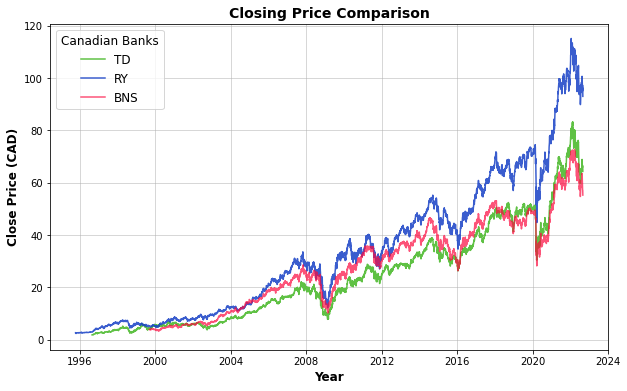

In [6]:
plt.figure(figsize=(10,6))
plt.grid(True, linewidth=0.5)

plt.plot(td_date, td_df['close'], label='TD', c='#5FC144', alpha=1, linewidth=1.5)
plt.plot(ry_date, ry_df['close'], label='RY', c='#1741C6', alpha=0.85, linewidth=1.5)
plt.plot(bns_date, bns_df['close'], label='BNS', c='#FC0A3F', alpha=0.7, linewidth=1.5)

plt.xlabel('Year', weight="bold", size=12)
plt.ylabel('Close Price (CAD)', weight="bold", size=12)
plt.title('Closing Price Comparison', weight="bold", size=14)
plt.legend(fontsize="large", title="Canadian Banks", title_fontsize=12)
plt.show()

## Closing price moving average

In [7]:
df = td_df.copy()
col = 'AdjustedClose'
periods = [5,10,20,30,50]
for period in periods:
    df.loc[:,"MovingAvg_{}Day".format(period)] = df['close'].rolling(window=period).mean().values

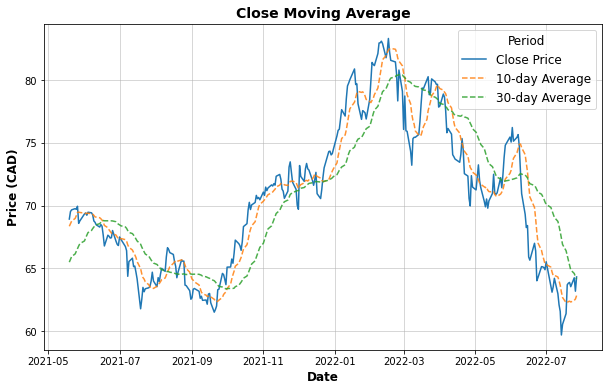

In [8]:
plt.figure(figsize=(10,6))
plt.grid(True, linewidth=0.5)

plt.plot(td_date[6220:6520], df['close'][6220:6520], label='Close Price', alpha=1, linewidth=1.5)
plt.plot(td_date[6220:6520], df['MovingAvg_10Day'][6220:6520], label='10-day Average', linestyle='--', alpha=0.85, linewidth=1.5)
plt.plot(td_date[6220:6520], df['MovingAvg_30Day'][6220:6520], label='30-day Average', linestyle='--', alpha=0.85, linewidth=1.5)

plt.xlabel('Date', weight="bold", size=12)
plt.ylabel('Price (CAD)', weight="bold", size=12)
plt.title('Close Moving Average', weight="bold", size=14)
plt.legend(fontsize="large", title="Period", title_fontsize=12)
plt.show()

## Combining stock price + close moving average

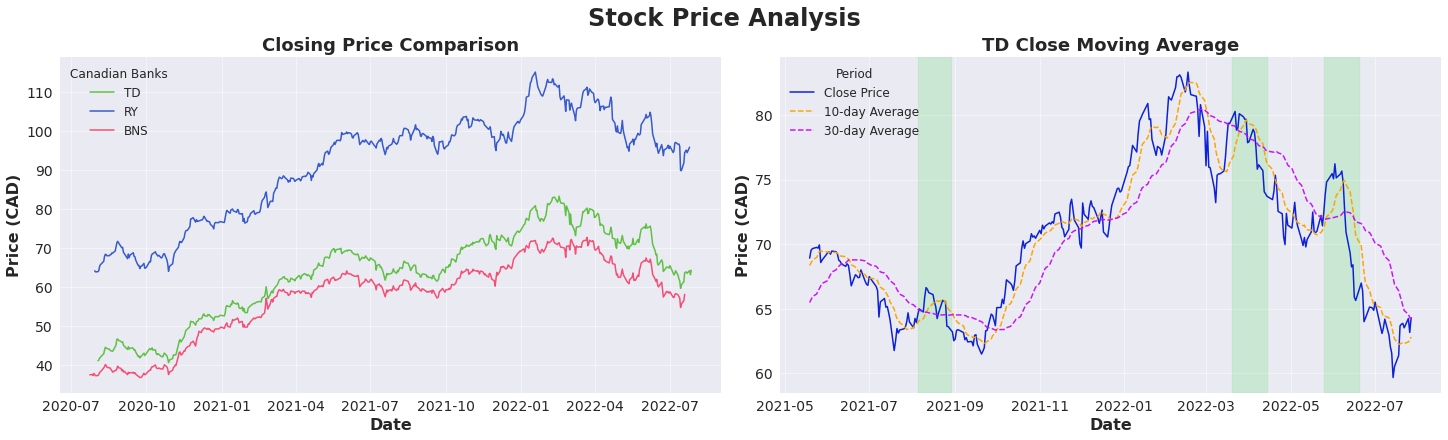

In [9]:
plt.style.use('seaborn')
fig, axs = plt.subplots(1,2,figsize=(20,6), constrained_layout=True)

fig.suptitle('Stock Price Analysis', weight="bold", size=24)
axs[0].grid(True, linewidth=0.5)

axs[0].plot(td_date[6020:6520], td_df['close'][6020:6520], label='TD', c='#5FC144', alpha=1, linewidth=1.5)
axs[0].plot(ry_date[6240:6740], ry_df['close'][6240:6740], label='RY', c='#1741C6', alpha=0.85, linewidth=1.5)
axs[0].plot(bns_date[5250:5750], bns_df['close'][5250:5750], label='BNS', c='#FC0A3F', alpha=0.7, linewidth=1.5)

axs[0].set_xlabel('Date', weight="bold", size=16)
axs[0].set_ylabel('Price (CAD)', weight="bold", size=16)
axs[0].set_title('Closing Price Comparison', weight="bold", size=18)
axs[0].legend(fontsize="large", title="Canadian Banks", title_fontsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
  label.set_fontsize(14)

axs[1].grid(True, linewidth=0.5)

axs[1].plot(td_date[6220:6520], df['close'][6220:6520], label='Close Price', color='#0D22D6', alpha=1, linewidth=1.5)
axs[1].plot(td_date[6220:6520], df['MovingAvg_10Day'][6220:6520], label='10-day Average', linestyle='--', color='orange', alpha=1.0, linewidth=1.5)
axs[1].plot(td_date[6220:6520], df['MovingAvg_30Day'][6220:6520], label='30-day Average', linestyle='--', color='#C50AFC', alpha=0.95, linewidth=1.5)

axs[1].set_xlabel('Date', weight="bold", size=16)
axs[1].set_ylabel('Price (CAD)', weight="bold", size=16)
axs[1].set_title('TD Close Moving Average', weight="bold", size=18)
axs[1].legend(fontsize="large", title="Period", title_fontsize=12, loc='upper left')
axs[1].axvspan(*mdates.datestr2num(['8/5/2021','8/30/2021']), color='#0DD622', alpha=0.15)
axs[1].axvspan(*mdates.datestr2num(['3/20/2022','4/15/2022']), color='#0DD622', alpha=0.15)
axs[1].axvspan(*mdates.datestr2num(['5/25/2022','6/20/2022']), color='#0DD622', alpha=0.15)

for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
  label.set_fontsize(14)

plt.savefig('stock_analysis.png')
plt.show()

## Observations

* Closing price comparison between top 3 banks in Canada:
  * Shows similar pattern. Uptrend from Oct 2020 to June 2021 (8 months). Downtrend from July to October 2021 (3 months). Uptrend again from Oct 2021 to Mar 2022 (5 months). Downtrend from April to July 2022 (3 months). Why are the overall trends similar? 

* TD close moving average:
  * When the shorter period, the 10-Day average exceeds above the longer period, the 30-Day average, the closing price tends to decrease, which typically indicates a buy signal.

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#003566;overflow:hidden">4. Predictive Analysis-SARIMA</div>

ARIMA isnt able to handle seasonality. 

**SARIMAX**: **S**easonal **A**uto **R**egressive **I**ntegrated **M**oving **A**verage with e**X**ogenus factors

To fit a SARIMAX, we need to define values for parameters p, d and q, where:
* **p** is the number of autoregressive terms
* **d** is the number of non-seasonal differences needed for stationarity
* **q** is the number of lagged forecast errors in the prediction equation

## [Components of a time series](https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467)

What is time series decomposition?
* A time series is composed of **Trend**, **Seasonality**, **Cyclic**, and **Ressidual/ Random** components.

$$ U_t = T_t + S_t + C_t + R_t $$



## Determine if the data is seasonal or not

In [10]:
y = td_df.reset_index()[['date','close']][6045:6545]

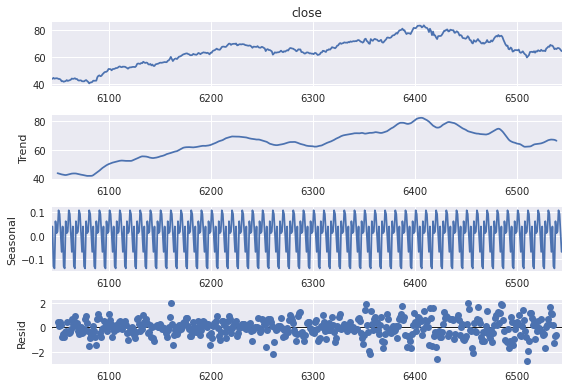

In [11]:
decomposition = sm.tsa.seasonal_decompose(y['close'], model='additive', period=10)
fig = decomposition.plot()
plt.show()


**Observations**:
* Seasonal data

## SARIMA modeling

In [12]:
# Start 31-08-2020 End 31-08-2022
td_df_subset_s = td_df[6045:6545].copy()
td_df_subset_s 

,open,high,low,close,volume
date,,,,,
2020-09-08,44.1335,44.3274,43.7458,43.9858,1621202
2020-09-09,44.3367,44.9599,44.1982,44.6783,1924572
2020-09-10,45.0384,45.0384,43.9673,44.0689,1321336
2020-09-11,44.1705,44.5675,44.1151,44.3090,1121290
2020-09-14,44.6875,44.7891,44.2813,44.3921,1121930
...,...,...,...,...,...
2022-08-25,66.9500,67.5600,66.4400,66.6100,1734355
2022-08-26,67.2100,68.0314,66.3801,66.6000,2232821
2022-08-29,66.3100,66.5100,65.3500,66.2000,1973475


In [13]:
train_data_s, test_data_s = td_df_subset_s[0:int(len(td_df_subset_s)*0.8)], td_df_subset_s[int(len(td_df_subset_s)*0.8):]

In [14]:
smodel = auto_arima(td_df_subset_s['close'], start_p=1, start_q=1,
                    test='adf',
                    max_p=3, max_q=3,
                    m=30, #30 days, frequency
                    start_P=0, seasonal=True,
                    d=None, D=1, trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=29.67 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=2876.781, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=1384.420, Time=9.25 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=2340.339, Time=8.20 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=2909.485, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=1481.403, Time=0.90 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=1345.795, Time=23.75 sec
 ARIMA(1,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=52.60 sec
 ARIMA(1,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=18.38 sec
 ARIMA(0,0,0)(2,1,0)[30] intercept   : AIC=2870.166, Time=12.17 sec
 ARIMA(2,0,0)(2,1,0)[30] intercept   : AIC=1346.726, Time=22.12 sec
 ARIMA(1,0,1)(2,1,0)[30] intercept   : AIC=1346.633, Time=24.96 sec
 ARIMA(0,0,1)(2,1,0)[30] intercept   : AIC=2339.232, Time=20.40 sec
 ARIMA(2,0,1)(2,1,0)[30] intercept   : AIC=1344.055, Time=42.38 sec
 ARIMA(2,0,1)(1,1,0)[30] 

## Forecasting

In [15]:
# Forecast
n_periods = 30*3 # for the next 3 months
s_fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True) # forecast on a daily basic
index_of_fc = pd.date_range(td_df_subset_s.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(s_fitted.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

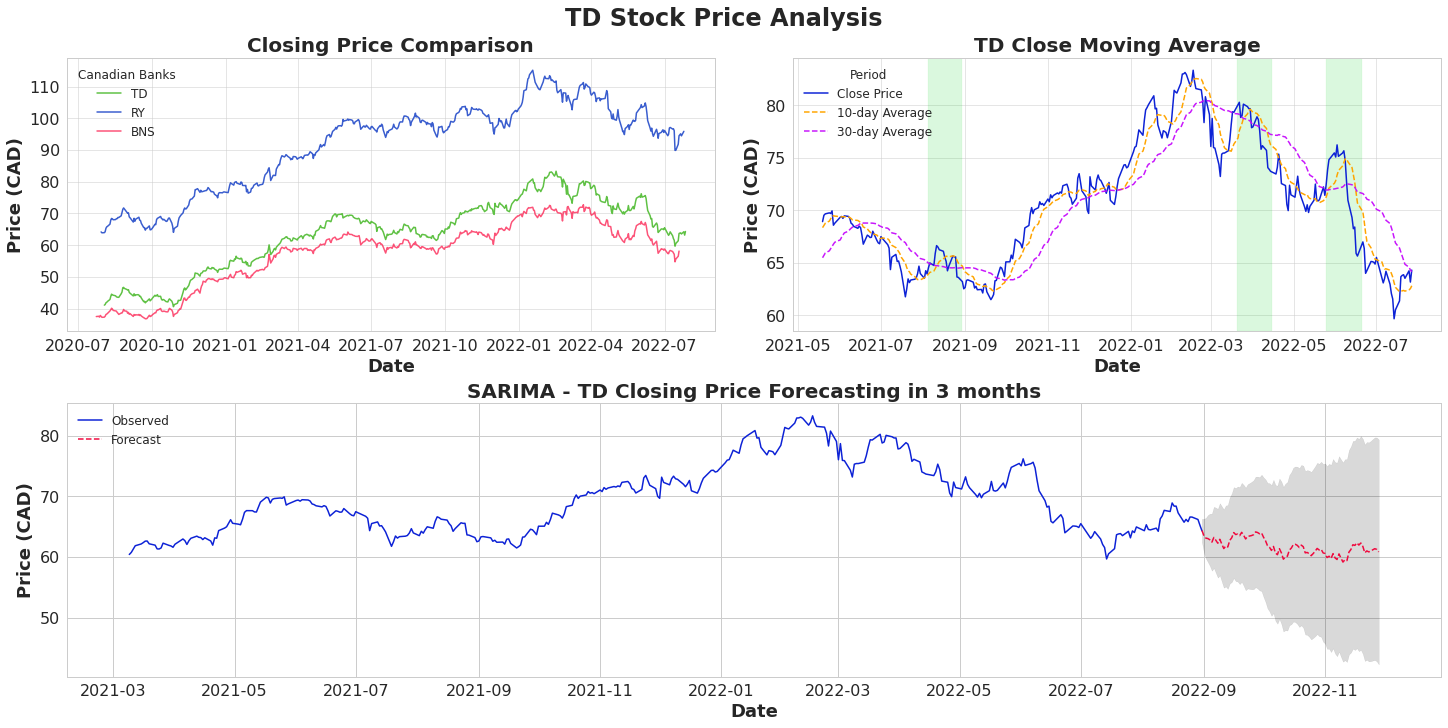

In [16]:
plt.style.use('seaborn-whitegrid')
fig1 = plt.figure(figsize=(20,10), constrained_layout=True)

axs = fig1.subplot_mosaic(
    """
    AB
    CC
    """
)

fig1.suptitle('TD Stock Price Analysis', weight="bold", size=24)
axs['A'].grid(True, linewidth=0.5)

axs['A'].plot(td_date[6020:6520], td_df['close'][6020:6520], label='TD', c='#5FC144', alpha=1, linewidth=1.5)
axs['A'].plot(ry_date[6240:6740], ry_df['close'][6240:6740], label='RY', c='#1741C6', alpha=0.85, linewidth=1.5)
axs['A'].plot(bns_date[5250:5750], bns_df['close'][5250:5750], label='BNS', c='#FC0A3F', alpha=0.7, linewidth=1.5)

axs['A'].set_xlabel('Date', weight="bold", size=18)
axs['A'].set_ylabel('Price (CAD)', weight="bold", size=18)
axs['A'].set_title('Closing Price Comparison', weight="bold", size=20)
axs['A'].legend(fontsize="large", title="Canadian Banks", title_fontsize=12)
for label in (axs['A'].get_xticklabels() + axs['A'].get_yticklabels()):
    label.set_fontsize(16)

axs['B'].grid(True, linewidth=0.5)

axs['B'].plot(td_date[6220:6520], df['close'][6220:6520], label='Close Price', color='#0D22D6', alpha=1, linewidth=1.5)
axs['B'].plot(td_date[6220:6520], df['MovingAvg_10Day'][6220:6520], label='10-day Average', linestyle='--', color='orange', alpha=1.0, linewidth=1.5)
axs['B'].plot(td_date[6220:6520], df['MovingAvg_30Day'][6220:6520], label='30-day Average', linestyle='--', color='#C50AFC', alpha=0.95, linewidth=1.5)

axs['B'].set_xlabel('Date', weight="bold", size=18)
axs['B'].set_ylabel('Price (CAD)', weight="bold", size=18)
axs['B'].set_title('TD Close Moving Average', weight="bold", size=20)
axs['B'].legend(fontsize="large", title="Period", title_fontsize=12, loc='upper left')
axs['B'].axvspan(*mdates.datestr2num(['8/5/2021','8/30/2021']), color='#0DD622', alpha=0.15)
axs['B'].axvspan(*mdates.datestr2num(['3/20/2022','4/15/2022']), color='#0DD622', alpha=0.15)
axs['B'].axvspan(*mdates.datestr2num(['5/25/2022','6/20/2022']), color='#0DD622', alpha=0.15)

for label in (axs['B'].get_xticklabels() + axs['B'].get_yticklabels()):
    label.set_fontsize(16)

axs['C'].plot(td_df_subset_s.index[125:], td_df_subset_s.close[125:], label='Observed', color='#0D22D6', alpha=1, linewidth=1.5)
axs['C'].plot(fitted_series, linestyle='--', label='Forecast', color='#F0083D', linewidth=1.5)
axs['C'].fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
for label in (axs['C'].get_xticklabels() + axs['C'].get_yticklabels()):
    label.set_fontsize(16)

axs['C'].set_xlabel('Date', weight="bold", size=18)
axs['C'].set_ylabel('Price (CAD)', weight="bold", size=18)
axs['C'].legend(loc='upper left',fontsize='large')
axs['C'].set_title("SARIMA - TD Closing Price Forecasting in 3 months", weight="bold", size=20 )


plt.savefig('stock_analysis.png')
plt.show()

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#003566;overflow:hidden">5. XGBoost</div>

## Time Series Cross-Validation (CV)


In [20]:
# Instantiate a Time Series cross-validator with test_size = 1 year with no gap
tts = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=0)

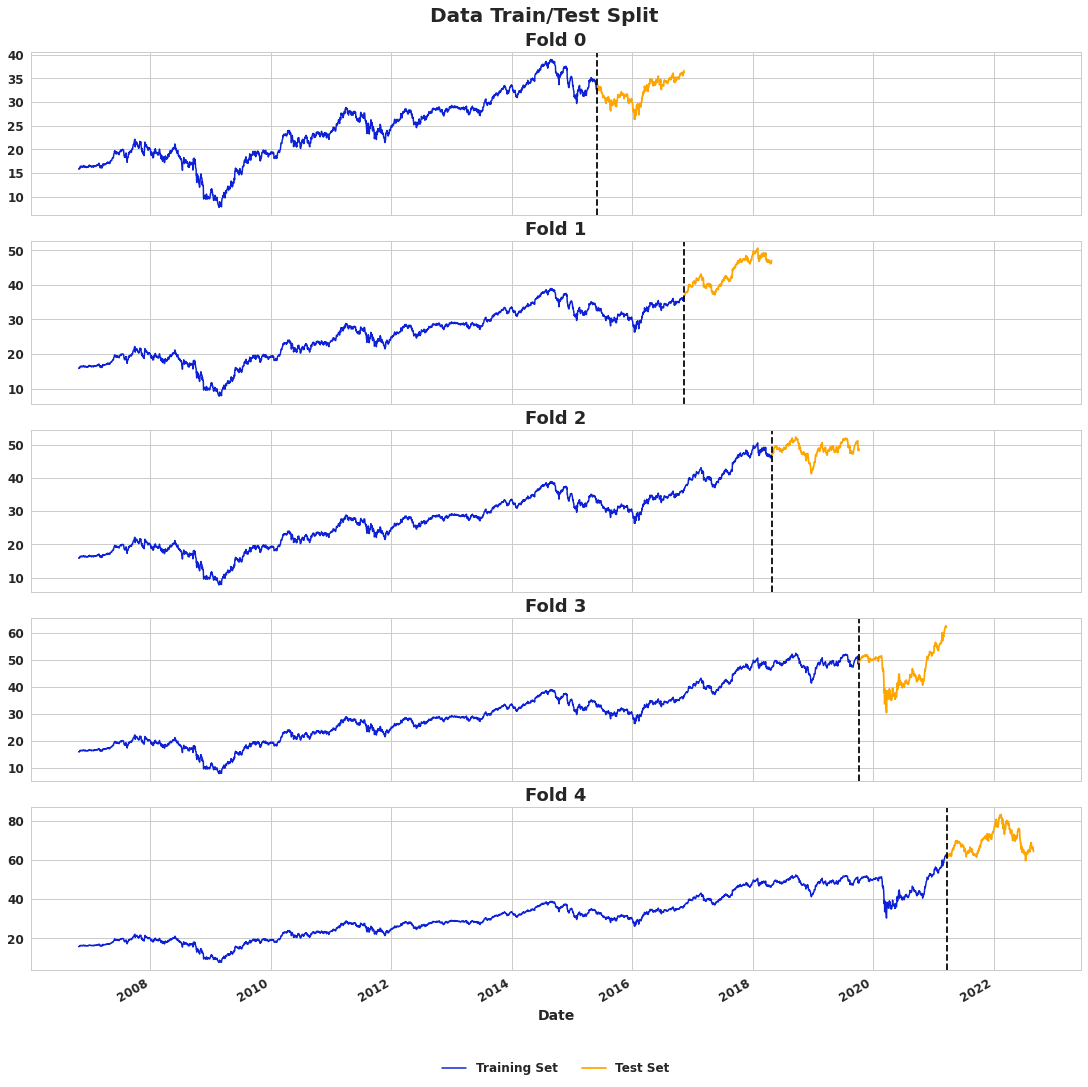

In [57]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True, constrained_layout=True)

fig.suptitle('Data Train/Test Split', weight="bold", size=20)

fold = 0
for train_idx, val_idx in tts.split(td_df[365*7:]):
    train = td_df[365*7:].iloc[train_idx]
    test = td_df[365*7:].iloc[val_idx]
    train['close'].plot(ax=axs[fold],
                        label='Training Set',
                        color='#0D22D6', linewidth=1.5,
                       )
    test['close'].plot(ax=axs[fold],
                       label='Test Set', c='orange')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].set_title(f'Fold {fold}', size=18, weight='bold')
    
    for label in (axs[fold].get_xticklabels() + axs[fold].get_yticklabels()):
        label.set_fontsize(12)
   
    fold += 1
axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=5, prop={'size': 12, 'weight': "bold"})

axs[4].set_xlabel('Date', size=14, weight="bold")

plt.show()

## Forecasting Horizon

* Short-term horizon: less than three months
* Long-term horizon: more than two years

In [67]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(td_df[365*7:])

## Lag Features

In [69]:
def add_lags(df):
    target_map = df['close'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [70]:
df = add_lags(df)

## Training

In [120]:
tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=0)
df = df.sort_index()


fold = 0
preds = []
scores = []
reg = None
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'close'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:24.39278	validation_1-rmse:31.58087
[100]	validation_0-rmse:9.08360	validation_1-rmse:9.96197
[200]	validation_0-rmse:3.55559	validation_1-rmse:2.76413
[293]	validation_0-rmse:1.75249	validation_1-rmse:2.67073
[0]	validation_0-rmse:25.56036	validation_1-rmse:42.82894
[100]	validation_0-rmse:9.53024	validation_1-rmse:22.79201
[200]	validation_0-rmse:3.76716	validation_1-rmse:16.04786
[300]	validation_0-rmse:1.80843	validation_1-rmse:14.06608
[400]	validation_0-rmse:1.25291	validation_1-rmse:13.33215
[500]	validation_0-rmse:1.08637	validation_1-rmse:13.11727
[600]	validation_0-rmse:1.02206	validation_1-rmse:13.05524
[700]	validation_0-rmse:0.97340	validation_1-rmse:13.02031
[769]	validation_0-rmse:0.95207	validation_1-rmse:13.01914
[0]	validation_0-rmse:28.30462	validation_1-rmse:47.89010
[100]	validation_0-rmse:10.55738	validation_1-rmse:19.13519
[200]	validation_0-rmse:4.18111	validation_1-rmse:9.52932
[300]	validation_0-rmse:2.07266	validation_1-rmse:6.04724
[400

In [110]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.2307
Fold scores:[2.2735124114188543, 13.016017188698667, 3.652781619848097, 7.275337120697089, 14.935884439033249]


## Feature importance

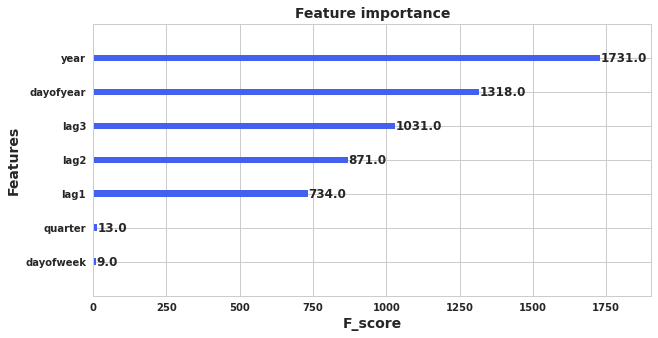

In [168]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
xgb.plot_importance(reg, ax=ax, color='#4361ee')
ax.set_xlabel('F_score', weight="bold", size=14)
ax.set_ylabel('Features', weight="bold", size=14)
ax.set_title('Feature importance', weight='bold', size=14)
plt.rcParams.update({'font.size': 12})

## Predicting the future

* Retraining on all data
* To Predict the future we need an emtpy dataframe for future date ranges.
* Run those dates through our feature creation code + lag creation


### Feature Preparation

In [111]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'close'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:17:34] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:37.66489
[100]	validation_0-rmse:14.15983
[200]	validation_0-rmse:5.83322
[300]	validation_0-rmse:3.10530
[400]	validation_0-rmse:2.33269
[499]	validation_0-rmse:2.08594


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [112]:
df.index.max()

Timestamp('2022-08-31 00:00:00')

In [113]:
# Create future dataframe
future = pd.date_range('2022-08-31','2023-08-29', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [114]:
df_and_future.tail()

,open,high,low,close,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2023-08-25,NaN,NaN,NaN,NaN,NaN,4,3,8,2023,237,25,34,66.60,63.6166,46.3494,True
2023-08-26,NaN,NaN,NaN,NaN,NaN,5,3,8,2023,238,26,34,NaN,NaN,NaN,True
2023-08-27,NaN,NaN,NaN,NaN,NaN,6,3,8,2023,239,27,34,NaN,NaN,NaN,True
2023-08-28,NaN,NaN,NaN,NaN,NaN,0,3,8,2023,240,28,35,66.20,63.2122,46.0355,True
2023-08-29,NaN,NaN,NaN,NaN,NaN,1,3,8,2023,241,29,35,65.24,62.5285,45.8416,True


In [115]:
future_w_features = df_and_future.query('isFuture').copy()

### Forecasting

In [116]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [91]:
train = df.copy()
test = df.copy()
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx].copy()
    test = df.iloc[val_idx].copy()

In [94]:
train.shape, test.shape

((3625, 16), (365, 16))

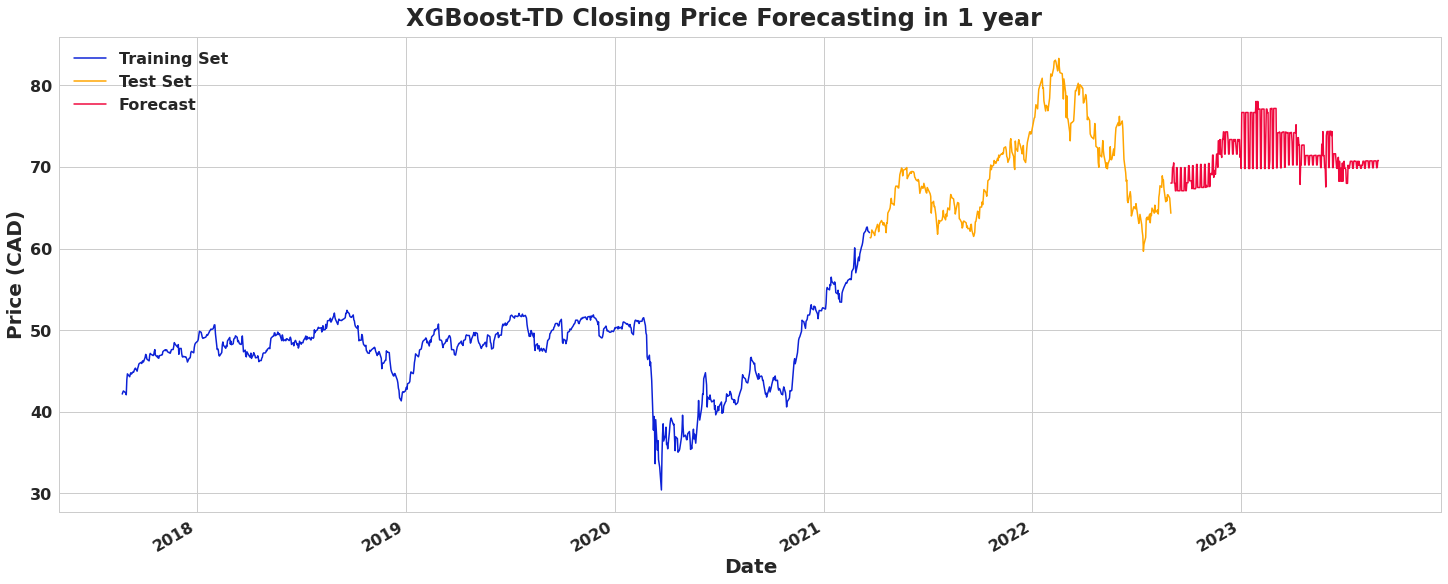

In [173]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8), sharex=True, constrained_layout=True)
fig.suptitle('XGBoost-TD Closing Price Forecasting in 1 year', size=24, weight="bold")
train[2725:]['close'].plot(ax=axs, label='Training Set',
                            color='#0D22D6', linewidth=1.5)
test['close'].plot(ax=axs, label='Test Set', color='orange',
                   linewidth = 1.5)
future_w_features['pred'].plot(color='#F0083D', label='Forecast',
                               linewidth=1.5, linestyle='-'
                              )
axs.set_xlabel('Date', size=20, weight="bold")
axs.set_ylabel('Price (CAD)', size=20, weight="bold")
axs.legend(loc='upper left', prop={'size': 16})

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(16)
plt.show()

## Model saving

In [102]:
# Save model
reg.save_model('model.json')

In [103]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')